In [2]:
#Import necessary libraries

import os
import time
import hashlib
import subprocess
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
import re

from scipy.interpolate import interp1d
from scipy.signal import argrelmin
from scipy.ndimage import label
from scipy.signal import argrelextrema
from matplotlib.lines import Line2D
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed




In [3]:
#Define functions and classes.

def load_sample_subset(filepath):
    """ 
    Load a stellar sample from a CSV file and extract relevant columns.

    Parameters:
    -----------
    filepath : str
        Path to the CSV file containing the stellar sample.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing only the selected columns.
    
    """
        
    # Define the columns to extract
    columns = [
        'primary_name', 'Mass', 'Teff(K)',
        'Mass-err', 'Mass+err', 'Teff_err(K)',
        'logLuminosity', 'logLuminosity-err', 'logLuminosity+err'
    ]

    # Load the full sample and return only the desired columns
    sample = pd.read_csv(filepath)
    return sample[columns]

#---------------------------------------------------#

def create_dir(ID):
    """
    Creates a directory named after the star ID if it does not already exist.
    
    """
    base_dir = os.path.join(f'./{ID}')
    
    try:
        os.makedirs(base_dir, exist_ok=True)
        print(f"Directory '{base_dir}' created (or already exists).")
    except Exception as e:
        print(f"An error occurred while creating directory: {e}")

#---------------------------------------------------#

class model():
    """ 
    This is the initialization function that runs when an instance of the model class is created. 
    
    """
    
    def __init__(self, nu):
        self.nu = nu
        self.N_p = np.arange(0, 40, 1) # Number of radial modes (l=0)
        self.vis={'V20': 1.02, 'V10': 1.35} # V20 and V10 are the visibility factors for l=2 and l=1 modes, respectively for HARPS (535 nm): Handberg and Campante (2011).
        
        
    def asymptotic_nu_p(self, numax, dnu, **kwargs):
        """
        Compute the l=0 mode frequencies from the asymptotic relation for p-modes (Nielson et al. 2021).
    
        Parameters
        ----------
        numax : float
            Frequency of maximum power of the p-mode envelope (muHz).
        dnu : float
            Large separation of l=0 modes (muHz).
        eps_p : float
            Epsilon phase term in asymptotic relation (unitless).
        alpha_p : float
            Curvature factor of l=0 ridge (second order term, unitless).
    
        Returns
        -------
        nu0s : ndarray
            Array of l=0 mode frequencies from the asymptotic relation (muHz).
        
        """
        
        eps_p = 1.45 #White et al. 2011
        n_p_max = numax / dnu - eps_p
        n_max = numax / dnu
        a_MS = 0.57 #Mosser et al. 2013
        
        n_p_max = numax / dnu 
        alpha_p = 2 * a_MS * n_max**-2  #Mosser et al. 2013

        return (self.N_p + eps_p + alpha_p/2*(self.N_p - n_p_max)**2) * dnu
        
    
    def lor(self, nu0, h, w):
        """
        Lorentzian to describe an oscillation mode.

        Parameters
        ----------
        nu0 : float
            Frequency of lorentzian (muHz).
        h : float
            Height of the lorentizan (SNR).
        w : float
            Full width of the lorentzian (muHz).

        Returns
        -------
        mode : ndarray
            The SNR as a function frequency for a lorentzian.
        
        """

        return h / (1.0 + 4.0/w**2*(self.nu - nu0)**2)

    def compute_A_rms_max(self, L, M, T):
        """
        Compute maximum RMS RV amplitude, A_max [m/s] using scaling relations. (Kjeldsen & Bedding 2011)

        Parameters
        ----------
        L : float
            Stellar luminosity (solar units)
        M : float
            Stellar mass (solar units)
        T : float
            Effective temperature (K)

        Returns
        -------
        A_max : float
            Maximum amplitude
        
        """
        
        A_max_sun = 0.234           # +/- 0.014 m/s velocity Amplitude of Sun (Kjeldsen & Bedding 1994)
        Tau_sun = 2.88              #days (mode lifetime of Sun Kjeldsen & Bedding 2011)
        L_sun = M_sun = 1           #Solar luminosity and mass in solar units
        T_sun = 5777                #Solar effective temperature in Kelvin
        Tau = Tau_sun * (T/T_sun) ** -3.7     #Chaplin et al 2009

        A_max = A_max_sun * ((L/L_sun * (Tau/Tau_sun) ** 0.5 ) / (((M/M_sun) ** 1.5) * ((T/T_sun) ** 2.25))) 
        return A_max
    

    def compute_env_width(self, T, numax):
        """
        Compute the FWHM of the power envelope (Ball et al. 2018).

        Parameters
        ----------
        T : float
            Effective temperature (K)
        numax : float
            Frequency of maximum power (μHz)

        Returns
        -------
        sig_env : float
            Standard deviation of the Gaussian envelope
        
        """
                
        T_sun = 5777 # Solar temperature
        FWHM_env = 0.66 * (numax ) ** 0.88
        if T > T_sun:
            FWHM_env *= 1 + 6e-4 * (T - T_sun)

        sig_env = FWHM_env / (2 * np.sqrt(2 * np.log(2)))
        
        return sig_env

    def compute_mode_width_1(self, nu, nu_max, T_eff):
        """
        Estimate the linewidth (FWHM) of solar-like oscillation modes at given frequencies (Ball et al. 2018),
        with optional maximum mode width cutoff.
        
        Parameters
        ----------
        nu : ndarray
            Frequencies (μHz) at which to compute the mode linewidths.
        nu_max : float
            Frequency of maximum oscillation power (μHz), a proxy for stellar evolutionary state.
        T_eff : float
            Effective temperature of the star (Kelvin).

        Returns
        -------
        widths : ndarray
            Mode linewidths (μHz) at the input frequencies.
        
        """
        # Coefficients
        a1, b1, c1 = -3.710e0,   1.073e-3,   1.883e-4
        a2, b2, c2 = -7.209e1,   1.543e-2,   9.101e-4
        a3, b3, c3 = -2.266e-1,  5.083e-5,   2.715e-6
        a4, b4, c4 = -2.190e3,   4.302e-1,   8.427e-1
        a5, b5, c5 = -5.639e-1,  1.138e-4,   1.312e-4
        
       

        alpha        = a1 + b1 * T_eff + c1 * nu_max
        gam_alpha    = a2 + b2 * T_eff + c2 * nu_max
        del_gam_dip  = a3 + b3 * T_eff + c3 * nu_max
        nu_dip       = a4 + b4 * T_eff + c4 * nu_max
        W_dip        = a5 + b5 * T_eff + c5 * nu_max
        
        eps = 1e-10
        del_gam_dip = np.maximum(del_gam_dip, eps)
        gam_alpha = np.maximum(gam_alpha, eps)
        nu_ratio = np.maximum(nu / nu_max, eps)
        nu_dip_ratio = np.maximum(nu / nu_dip, eps)
        wdip_ratio = np.maximum(W_dip / nu_max, eps)

        log_ratio = np.log(nu_ratio)
        log_wdip_ratio = np.log(wdip_ratio)
        dip_term = np.log(del_gam_dip) / (1 + (2 * np.log(nu_dip_ratio) / log_wdip_ratio) ** 2)

        width = np.exp(alpha * log_ratio + np.log(gam_alpha) + dip_term)

        return width

    
    def compute_mode_width_2(self, nu, numax, T_eff, min_width=1.2e-5, 
                      a_left=1e-4, p_left=1.2, a_right=3e-4, p_right=1.35, max_width=None):
        """
        Compute a asymmetric mode linewidth profile centered on numax,
        used for cool stars (T_eff < 4500 K).

        Parameters
        ----------
        nu : float or ndarray
            Mode frequency (μHz)
        numax : float
            Frequency of maximum oscillation power (μHz)
        T_eff : float
            Effective temperature (K)
        min_width : float
            Minimum mode width at numax (μHz)
        a_left, p_left : float
            Amplitude and power law exponent for the left (ν < ν_max) slope
        a_right, p_right : float
            Amplitude and power law exponent for the right (ν > ν_max) slope
        max_width : float or None
            Maximum allowed mode width (μHz). If None, no max applied.

        Returns
        -------
        width : float or ndarray
            Frequency-dependent mode width (μHz)
        
        """
        T_eff_width = T_eff * min_width
    
        nu = np.atleast_1d(nu)  # Ensure array operations
        width = np.full_like(nu, T_eff_width, dtype=float)

        left_mask = nu < numax
        right_mask = nu > numax

        width[left_mask] += a_left * (numax - nu[left_mask])**p_left
        width[right_mask] += a_right * (nu[right_mask] - numax)**p_right

        if max_width is not None:
            width = np.minimum(width, max_width)

        return width if width.size > 1 else width[0]
    
    def compute_mode_power(self, nu, L, M, T, numax):
        """
        Compute the mode power at given frequency using the RMS amplitude envelope and Gaussian envelope width.

        Parameters
        ----------
        nu : float or ndarray
            Frequency of the mode (μHz)
        L : float
            Stellar luminosity (in L_sun)
        M : float
            Stellar mass (in M_sun)
        T : float
            Effective temperature (K)
        numax : float
            Frequency of maximum oscillation power (μHz)

        Returns
        -------
        power : float or ndarray
            Mode power at frequency nu
        
        """
            
        A_max = self.compute_A_rms_max(L, M, T)
        sigma_env = self.compute_env_width(T, numax)
    
        mode_pow = A_max**2 * np.exp(-(nu - numax)**2 / (2 * sigma_env**2))
        return mode_pow  
     
        
    def addModes1(self, T_eff, L, M, numax, dnu, **kwargs):
        """
        Add oscillation modes (l=0,1,2) with frequency-dependent linewidths and power.
        Returns mode data used to create a .con file.
        
        """
        modes = np.zeros_like(self.nu)
        nu0_p = self.asymptotic_nu_p(numax, dnu, **kwargs)
        d02 = dnu * (9.0 / 135.1)
        d01 = dnu/2 - (dnu * (4.5 / 135.1))  #ok for now.
        
        

        mode_data = []

        for i, n in enumerate(self.N_p):
            nu_l0 = nu0_p[i]
            nu_l1 = nu_l0 + d01
            nu_l2 = nu_l0 - d02

           # --- Linewidths: use curved profile for cool stars ---
            if T_eff < 4500:
                width_l0 = self.compute_mode_width_2(nu_l0, numax, T_eff, max_width=10.0)
                width_l1 = self.compute_mode_width_2(nu_l1, numax, T_eff, max_width=10.0)
                width_l2 = self.compute_mode_width_2(nu_l2, numax, T_eff, max_width=10.0)
            else:
                width_l0 = self.compute_mode_width_1(nu_l0, numax, T_eff)
                width_l1 = self.compute_mode_width_1(nu_l1, numax, T_eff)
                width_l2 = self.compute_mode_width_1(nu_l2, numax, T_eff)

            # --- Mode powers ---
            power_l0 = self.compute_mode_power(nu_l0, L, M, T_eff, numax)
            power_l1 = self.compute_mode_power(nu_l1, L, M, T_eff, numax) * self.vis['V10']
            power_l2 = self.compute_mode_power(nu_l2, L, M, T_eff, numax) * self.vis['V20']

            # --- Heights from Power and Width ---
            height_l0 = (np.pi / 2) * power_l0 / width_l0
            height_l1 = (np.pi / 2) * power_l1 / width_l1
            height_l2 = (np.pi / 2) * power_l2 / width_l2

            # --- Add Lorentzians to power spectrum ---
            modes += self.lor(nu_l0, height_l0, width_l0)
            modes += self.lor(nu_l1, height_l1, width_l1)
            modes += self.lor(nu_l2, height_l2, width_l2)

            # --- Store mode data ---
            mode_data.append({"l": 0, "n": n, "nu": nu_l0, "linewidth": width_l0, "power": power_l0})
            mode_data.append({"l": 1, "n": n, "nu": nu_l1, "linewidth": width_l1, "power": power_l1})
            mode_data.append({"l": 2, "n": n, "nu": nu_l2, "linewidth": width_l2, "power": power_l2})

        return mode_data, modes
    
#---------------------------------------------------#

def generate_seed_hash(M, T_eff, numax):
    """
    Generates a reproducible integer seed based on M, T_eff, and numax
    using an MD5 hash.
    
    """
    
    s = f"{M:.6f}_{T_eff:.6f}_{numax:.6f}"
    h = hashlib.md5(s.encode()).hexdigest()
    # Uses the first 8 characters of the hash as a base-16 integer
    seed = int(h[:8], 16) % (2**31 - 1)  # ensures it's in 32-bit integer range
    return seed

#---------------------------------------------------#

def to_fortran_d0(val):
    """
    Convert numeric value to Fortran double precision string to be used in AADG3 input files.
    
    """
    
    if isinstance(val, (int, float)):
        return f"{val:.16g}d0"
    val_str = str(val).strip()
    
    # Already in Fortran format
    if re.fullmatch(r"[-+]?\d*\.?\d+([eEdD][-+]?\d+)?d0", val_str):
        return val_str
    
    # Check for non-numeric flags or file names
    if any(x in val_str.lower() for x in ['.true.', '.false.', '.con', '.asc', '.txt']):
        return val_str

    # Attempt conversion if it's a plain numeric string
    try:
        float_val = float(val_str)
        return f"{float_val:.16g}d0"
    except ValueError:
        return val_str  # Return as is if not convertible
    
#---------------------------------------------------#

def create_config_file(ID, subfolder, **kwargs):
    """
    Creates a customizable configuration file named '{ID}.in' in the specified subfolder.

    Parameters:
        ID (str): Identifier for the configuration file.
        subfolder (str): Path to the subfolder where the config file will be created.
        **kwargs: Optional keyword arguments to customize the configuration parameters.
    
    """

    # Ensure the subfolder exists
    os.makedirs(subfolder, exist_ok=True)

    # Define default configuration parameters (Sun)
    config_params = {
        'user_seed': '225618852',
        'cadence': '1d0',                 # Cadence of 1 second.
        'n_cadences': '6220800',          # Total number of time steps in the time series (72 days at 1 second cadence).
        'sig': '60d0',                    # Typical solar granulation amplitude.
        'rho': '0d0',                     # Correlation coefficient for red noise model (0 for no correlation).    
        'tau': '250d0',                   # Typical solar timescale for granulation in seconds.    
        'n_relax': '86400d0',             # Number of relaxation steps before collecting data (1 day).
        'n_fine': '50',                   # Resolution factor for interpolation of model signals with periods = 0.143s or freq = 7 mHz.
        'inclination': '90d0',            # Edge on observation assumed.
        'p1': '1.35d0',                   # Visibility factor for l=1 modes, for HARPS (535 nm): Handberg and Campante (2011).
        'p2': '1.02d0',                   # Visibility factor for l=2 modes, for HARPS (535 nm): Handberg and Campante (2011).
        'p3': '0.48d0',                   # Visibility factor for l=3 modes, for HARPS (535 nm): Handberg and Campante (2011).
        'add_granulation': '.false.',
        'modes_filename': f'{ID}.con',
        'rotation_filename': '',
        'output_filename': f'{ID}.asc'
    }

    # Override defaults with any user-supplied parameters
    for key, value in kwargs.items():
        if key in config_params:
            config_params[key] = str(value)
        else:
            raise KeyError(f"Unknown configuration parameter: '{key}'")

    # Define the file path
    infile_path = os.path.join(subfolder, f"{ID}.in")

    # Define the content of the .in file
    infile_content = f"""\
    ! This input produces data for model {ID}. Frequencies, linewidths, and amplitudes were modeled based on stellar parameters and a constant rotation rate of 0 µHz.
    
    &controls
    user_seed = {config_params['user_seed']}
    cadence = {config_params['cadence']}
    n_cadences = {config_params['n_cadences']}
    sig = {config_params['sig']}
    rho = {config_params['rho']}
    tau = {config_params['tau']}
    n_relax = {config_params['n_relax']}
    n_fine = {config_params['n_fine']}
    inclination = {config_params['inclination']}
    p(1) = {config_params['p1']}
    p(2) = {config_params['p2']}
    p(3) = {config_params['p3']}
    add_granulation = {config_params['add_granulation']}
    modes_filename = '{config_params['modes_filename']}'
    rotation_filename = '{config_params['rotation_filename']}'
    output_filename = '{config_params['output_filename']}'
    /
    """

    # Write the content to the .in file
    with open(infile_path, 'w') as file:
        file.write(infile_content)

    #print(f"Configuration file '{infile_path}' created.")

#---------------------------------------------------#

def process_single_realisation(i, ID, N, M_samples, T_samples, L_samples, numax_samples, dnu_samples, NU_GRID,**config_overrides  # Optional configuration overrides for the .in file
):
    # Create a unique ID and subfolder for this realisation
    this_ID = f"{ID}_MC_{i+1}"
    subfolder = os.path.join(ID, f"MC_{i+1}")
    os.makedirs(subfolder, exist_ok=True)

    # Generate oscillation modes using the stellar model
    m = model(NU_GRID)
    model_data, modes = m.addModes1(
        T_eff=T_samples[i],
        L=L_samples[i],
        M=M_samples[i],
        numax=numax_samples[i],
        dnu=dnu_samples[i],
    )

    # Save oscillation modes to a .con file (columns: l, n, frequency, linewidth, power, dummy 0)
    mode_array = np.zeros((len(model_data), 6))
    for j, d in enumerate(model_data):
        mode_array[j] = [d["l"], d["n"], d["nu"], d["linewidth"], d["power"], 0]

    np.savetxt(
        os.path.join(subfolder, f"{this_ID}.con"),
        mode_array,
        fmt="%d %d %.1f %.1f %.1f %.1f"
    )

    # Save the synthetic power spectrum density to CSV
    pd.DataFrame({
        "nu": NU_GRID,
        "power": modes
    }).to_csv(
        os.path.join(subfolder, f"{this_ID}_PSD.csv"),
        index=False
    )

    # Generate a reproducible random seed from M, T_eff, and numax
    user_seed = generate_seed_hash(
        M_samples[i],
        T_samples[i],
        numax_samples[i]
    )

    # Create the configuration file for this realisation
    create_config_file(
        ID=this_ID,
        subfolder=subfolder,
        user_seed=str(user_seed),
        **config_overrides  # Allows user to override any config values
    )

    # Print progress
    #print(f"[{ID}] Realisation {i+1}/{N} saved in {subfolder}")

#----------------------------------------------------#
def numax(M, R, T_eff):
    numax_solar = 3050.0
    T_eff_solar = 5777.0
    return M * R**-2 * (T_eff/T_eff_solar)**-0.5 * numax_solar
  
#----------------------------------------------------#
  
def dnu(M, R):
    dnu_solar = 135.0 
    return M**0.5 / R**(3/2) * dnu_solar

#---------------------------------------------------#

def radius(T_eff, L):
    T_eff_solar = 5777.0
    return (L**0.5) * (T_eff / T_eff_solar)**(-2)

#---------------------------------------------------#

def sample_truncated_normal(mean, std, N):
    # Set bounds
    lower = max(mean - std, 1e-3)  # ensure strictly positive lower bound
    upper = mean + std

    return np.random.uniform(low=lower, high=upper, size=N)

#---------------------------------------------------#

def monte_carlo(index, sample_file, N, NU_GRID, **config_overrides):
    sample = pd.read_csv(sample_file)
    row = sample.loc[index]
    ID = row['primary_name']

    # Extract central values and errors
    M0, T0 = row['Mass'], row['Teff(K)']
    L0 = 10 ** row['logLuminosity']

    M_unc = 0.5 * (row['Mass+err'] - row['Mass-err'])
    T_unc = row['Teff_err(K)']
    L_unc = 0.5 * (10 ** row['logLuminosity+err'] - 10 ** row['logLuminosity-err'])

    # Generate Monte Carlo samples
    M_samples = sample_truncated_normal(M0, M_unc, N)
    T_samples = sample_truncated_normal(T0, T_unc, N)
    L_samples = sample_truncated_normal(L0, L_unc, N)

    R_samples = radius(T_samples, L_samples)
    numax_samples = numax(M_samples, R_samples, T_samples)
    dnu_samples = dnu(M_samples, R_samples)

    # Save MC parameters to CSV
    params_df = pd.DataFrame({
        "realisation": np.arange(1, N + 1),
        "M": M_samples,
        "R": R_samples,
        "Teff": T_samples,
        "L": L_samples,
        "numax": numax_samples,
        "dnu": dnu_samples
    })

    main_folder = ID
    os.makedirs(main_folder, exist_ok=True)
    csv_path = os.path.join(main_folder, f"{ID}_MC_parameters.csv")
    params_df.to_csv(csv_path, index=False)

    # Run parallel realisations
   
    with ProcessPoolExecutor(max_workers=8) as executor:
        futures = [
            executor.submit(
                process_single_realisation,
                i, ID, N,
                M_samples, T_samples, L_samples,
                numax_samples, dnu_samples, NU_GRID,
                **config_overrides
            )
            for i in range(N)
        ]
        for future in futures:
            future.result()

#---------------------------------------------------#

def load_star_data(sample, star_index, mc_index):
    """
    Load star data from CSV and .con files.
    
    Parameters:
    -----------
    sample : pandas.DataFrame
        DataFrame containing star information
    star_index : int
        Index of the star to select
    mc_index : int
        MC realisation number (1-based)
    
    Returns:
    --------
    dict : Dictionary containing all loaded data and metadata
    
    """
    
    # Get star data
    row = sample.loc[star_index]
    ID_base = row['primary_name']
    ID = f"{ID_base}_MC_{mc_index}"
    
    # File paths
    folder = f"./{ID_base}/MC_{mc_index}"
    mc_params_file = f"./{ID_base}/{ID_base}_MC_parameters.csv"
    file_path1 = os.path.join(folder, f"{ID}_PSD.csv")
    file_path2 = os.path.join(folder, f"{ID}.con")
    
    # Check if files exist
    if not os.path.exists(file_path1):
        raise FileNotFoundError(f"PSD file not found: {file_path1}")
    if not os.path.exists(file_path2):
        raise FileNotFoundError(f".con file not found: {file_path2}")
    if not os.path.exists(mc_params_file):
        raise FileNotFoundError(f"MC parameters file not found: {mc_params_file}")
    
    #print(f"Loading data for {ID}...")
    
    # Load data
    csv_file = pd.read_csv(file_path1)
    con_data = np.loadtxt(file_path2)
    mc_params = pd.read_csv(mc_params_file)
    
    # Sanity check
    if csv_file.empty or con_data.size == 0:
        raise ValueError("Loaded files are empty.")
    
    # Get MC parameters for this realisation
    mc_row = mc_params[mc_params['realisation'] == mc_index]
    if mc_row.empty:
        raise ValueError(f"MC realisation {mc_index} not found in parameters file")
    
    mc_row = mc_row.iloc[0]  # Get the first (and should be only) matching row
    
    # Extract data
    data = {
        'ID': ID,
        'ID_base': ID_base,
        'nu1': csv_file['nu'].values,               # Frequency baseline(μHz)
        'power1': csv_file['power'].values,         # Power spectrum density (PSD) [(m/s)^2/μHz]
        'l': con_data[:, 0],                        # Angular degree (l)
        'n': con_data[:, 1],                        # Radial order (n)
        'nu2': con_data[:, 2],                      # Mode Frequency(μHz)
        'linewidth': con_data[:, 3],                # Linewidth (μHz)
        'power2': con_data[:, 4],                   # Rms power (m/s)^2
        'numax': mc_row['numax'],                   # Frequency of maximum oscillation power (μHz) from MC
        'dnu': mc_row['dnu'],                       # Large frequency separation (μHz) from MC
        'Teff': mc_row['Teff'],                       # Effective temperature (K) from MC
    }
    
    return data

#---------------------------------------------------#

def plot_oscillation_modes(data, xlim=(0, 10000), figsize=(10, 6), fontsize=16):
    """
    Plot oscillation modes (PSD).
    
    Parameters:
    -----------
    data : dict
        Dictionary containing star data from load_star_data()
    xlim : tuple
        X-axis limits for the plot
    
    """
    
    plt.figure(figsize=figsize)
    plt.plot(data['nu1'], data['power1'], 
             label=f'Oscillation Modes for {data["ID"]}', color='purple')
    plt.xlabel("Frequency (μHz)", fontsize=fontsize)
    plt.ylabel('Power (m/s)$^2$/μHz', fontsize=fontsize)
    plt.title(f'Oscillation Modes for {data["ID"]}', fontsize=fontsize+2)
    plt.xlim(xlim)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
#---------------------------------------------------#

def plot_linewidth_vs_frequency(data, figsize=(10, 6),fontsize=16):
    """
    Plot mode width vs scaled frequency.
    
    Parameters:
    -----------
    data : dict
        Dictionary containing star data from load_star_data()
    figsize : tuple
        Figure size (width, height)
    
    """
    
    scaled_freq = (data['nu2'] - data['numax']) / data['dnu']
    
    plt.figure(figsize=figsize)
    plt.plot(scaled_freq, data['linewidth'], color='purple')
    plt.xlabel('$(\\nu - \\nu_{\\rm max})/\\Delta\\nu$', fontsize=fontsize)
    plt.ylabel('Mode Width [µHz]', fontsize=fontsize)
    plt.title(f'Mode Width vs Radial Order for {data["ID"]}', fontsize=fontsize+2)
    plt.tight_layout()
    plt.show()
    
#---------------------------------------------------#

def plot_amplitudes_by_degree(data,figsize=(10, 6), fontsize=16):
    """ Plot rms power by degree (l value).
    
    Parameters:
    -----------
    data : dict
        Dictionary containing star data from load_star_data()
    """
    
    scaled_freq = (data['nu2'] - data['numax']) / data['dnu']
    power2_ms = data['power2']
    amplitudes = np.sqrt(power2_ms) # in m/s
    
    plt.figure(figsize=figsize)
    plt.plot(scaled_freq, amplitudes, 'o', color='lightgray', alpha=0.6)
    
    colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'orange', 4: 'purple'}
    unique_l = np.unique(data['l'])
    
    for l_val in unique_l:
        mask = data['l'] == l_val
        if np.any(mask):
            sorted_indices = np.argsort(data['nu2'][mask])
            plt.plot(
                (data['nu2'][mask][sorted_indices] - data['numax']) / data['dnu'],
                np.sqrt(power2_ms[mask][sorted_indices]),
                label=f'l = {int(l_val)}',
                color=colors.get(int(l_val), 'black')
            )
    
    plt.xlabel('$(\\nu - \\nu_{\\rm max}) / \\Delta\\nu$', fontsize=fontsize)
    plt.ylabel('rms amplitude [(m/s)]', fontsize=fontsize)
    plt.title(f'Radial Mode Amplitudes for {data["ID"]}', fontsize=fontsize+2)
    plt.legend()
    plt.tight_layout()
    plt.show()

#---------------------------------------------------#

def plot_echelle_diagram(data, figsize=(10, 6), fontsize=16):
    """
    Plot Échelle diagram with frequency modulated by large frequency separation.
    
    Parameters:
    -----------
    data : dict
        Dictionary containing star data from load_star_data()
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    dict : Dictionary containing Δν₀₂ analysis results
    
    """
    
    # Extract frequencies and angular degrees
    nu = np.array(data['nu2']) # Mode frequencies (μHz)
    l = np.array(data['l'])     
    dnu = data['dnu']
    numax = data['numax']
    ID = data['ID']
    
    # Modulate frequency by large frequency separation Δν
    mod_freq = nu % dnu
    
    # Assign colors by angular degree
    color_map = {0: 'red', 1: 'green', 2: 'blue'}
    colors = [color_map.get(li, 'gray') for li in l]
    
    # Create plot
    plt.figure(figsize=figsize)
    plt.scatter(mod_freq, nu, c=colors, marker='o', edgecolor='k', s=80)
    plt.xlabel(f'Frequency mod Δν = {dnu:.2f} μHz', fontsize=fontsize)
    plt.xlim(0, dnu)
    plt.ylabel('Frequency [μHz]', fontsize=fontsize)
    plt.title(f'Échelle Diagram for {ID}', fontsize=fontsize+2)
    plt.grid(True)
    
    # Custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='l=0', 
               markerfacecolor='red', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='o', color='w', label='l=1', 
               markerfacecolor='green', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='o', color='w', label='l=2', 
               markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    ]
    plt.legend(handles=legend_elements, title="Angular Degree (l)", 
               loc='center left', bbox_to_anchor=(1, 0.4))
    
    # νmax horizontal line
    plt.axhline(numax, color='purple', linestyle='--', linewidth=2)
    mid_x = dnu / 2
    plt.text(mid_x, numax + 5, 'νmax', color='purple', ha='center')
    
    # --- Δν₀₂ Calculation (pair l=0 and l=2 modes) ---
    nu_l0 = np.sort(nu[l == 0])
    nu_l2 = np.sort(nu[l == 2])
    
    delta_nu_02 = []
    pairs = []
    
    for nu0 in nu_l0:
        # Find l=2 mode immediately below the current l=0 mode
        lower_l2 = nu_l2[nu_l2 < nu0]
        if len(lower_l2) > 0:
            closest_l2 = lower_l2[-1]  # max(l2) < nu0
            delta_nu_02.append(nu0 - closest_l2)
            pairs.append((closest_l2, nu0))
    
    # Calculate mean Δν₀₂
    results = {}
    if delta_nu_02:
        mean_delta_nu_02 = np.mean(delta_nu_02)
        results['mean_delta_nu_02'] = mean_delta_nu_02
        results['delta_nu_02_values'] = delta_nu_02
        results['pairs'] = pairs
        print(f"Mean δν₀₂: {mean_delta_nu_02:.3f} μHz")
        
        # Plot one representative Δν₀₂ line
        if pairs:
            mod_l2_0 = pairs[0][0] % dnu
            mod_l0_0 = pairs[0][1] % dnu
            plt.plot([mod_l2_0, mod_l0_0], [pairs[0][0], pairs[0][1]], 'k--', alpha=0.6)
            
            # Annotate
            mid_x = 0.5 * (mod_l0_0 + mod_l2_0)
            mid_y = 0.5 * (pairs[0][1] + pairs[0][0])
            plt.text(mid_x, mid_y, f'Δν₀₂ ≈ {mean_delta_nu_02:.2f} μHz', 
                    fontsize=10, color='black', rotation=90)
    else:
        print("No valid δν₀₂ pairs found.")
        results['mean_delta_nu_02'] = None
        results['delta_nu_02_values'] = []
        results['pairs'] = []
    
    # Final layout
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()
    
    return results

#---------------------------------------------------#

def analyze_star(sample, star_index=12, mc_index=45, xlim=(0, 10000), figsize=(10, 6)):
    """
    Complete analysis workflow for a single star.
    
    Parameters:
    -----------
    sample : pandas.DataFrame
        DataFrame containing star information
    star_index : int
        Index of the star to select (default: 12)
    mc_index : int
        MC realisation number (default: 45)
    xlim : tuple
        X-axis limits for oscillation modes plot (default: (0, 10000))
    figsize : tuple
        Figure size for linewidth plot (default: (10, 6))
    
    Returns:
    --------
    tuple : (data_dict, echelle_results)
        data_dict: Dictionary containing all loaded data and metadata
        echelle_results: Dictionary containing Δν₀₂ analysis results
    
    """
    
    # Load data
    data = load_star_data(sample, star_index, mc_index)
    
    # Generate all plots
    plot_oscillation_modes(data, xlim)
    plot_linewidth_vs_frequency(data, figsize)
    plot_amplitudes_by_degree(data)
    echelle_results = plot_echelle_diagram(data, figsize)
    
    return data, echelle_results

#---------------------------------------------------#

def run_aadg3_single(ID, base_path, aadg3_path, j):
    """
    Run AADG3 for a single realisation j (0-based index). 
    
    """
    
    star_dir = os.path.join(base_path, ID)
    star_dir_2 = os.path.join(star_dir, f"MC_{j+1}")
    input_file = f"{ID}_MC_{j+1}.in"

    try:
        result = subprocess.run(
            [aadg3_path, input_file],
            cwd=star_dir_2,
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        print(f"[✓] AADG3 run for {ID} MC_{j+1} completed.")
    except subprocess.CalledProcessError as e:
        print(f"[✗] AADG3 run for {ID} MC_{j+1} failed: {e.stderr.decode()}")
    except Exception as ex:
        print(f"[!] AADG3 run for {ID} MC_{j+1} error: {ex}")
            
#---------------------------------------------------#

def run_all_realisations_parallel(ID, base_path, aadg3_path, N):
    #max_threads = min(multiprocessing.cpu_count(), N)  # Don't spawn more processes than realisations
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(run_aadg3_single, ID, base_path, aadg3_path, j) for j in range(N)]
        for future in futures:
            future.result()
    
#---------------------------------------------------#

def plot_synthetic_time_series(sample, index, realisation, base_path, fontsize=16):
    """
    Plot the synthetic time series for a given star and realisation.

    Parameters:
    - sample: DataFrame containing star info (must include 'primary_name' and 'numax' columns)
    - index: int, row index of the star in the DataFrame
    - realisation: int, realisation number (1-based)
    - base_path: str, base directory where the AADG3 outputs are stored

    Returns:
    - ID: The primary name of the star plotted
    
    """
    
    row = sample.loc[index]
    ID = row['primary_name']
    
    asc_path = os.path.join(base_path, f"{ID}/MC_{realisation}/{ID}_MC_{realisation}.asc")
    infile_path = os.path.join(base_path, f"{ID}/MC_{realisation}/{ID}_MC_{realisation}.in")

    flux = np.loadtxt(asc_path)
    cadence = read_cadence_from_infile(infile_path)

    # Construct the time axis
    n_points = len(flux)
    time = np.arange(n_points) * cadence

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, flux, lw=0.5, color='purple')
    plt.xlabel("Time (days)", fontsize=fontsize)
    plt.ylabel("RV [m/s]", fontsize=fontsize)
    plt.title(f"Synthetic time series for {ID}_MC_{realisation}", fontsize=fontsize+2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ID

#---------------------------------------------------#

import numpy as np

def process_realisation_star(filepath, ints, T_fixed):
    """
    Efficiently compute std of binned means for different integration times.
    
    """
    
    ts = np.loadtxt(filepath)

    if np.any(np.isnan(ts)):
        return None

    total_len = len(ts)
    std_dev = []

    for exposure in ints:
        npts = round(T_fixed / exposure)
        if npts == 0:
            std_dev.append(np.nan)
            continue

        exact_exposure = T_fixed / npts
        seg_len = int(exact_exposure)

        needed_len = npts * seg_len
        if needed_len > total_len:
            std_dev.append(np.nan)
            continue

        # Vectorized reshaping and mean/std
        reshaped = ts[:needed_len].reshape(npts, seg_len)
        seg_means = reshaped.mean(axis=1)
        std_dev.append(seg_means.std())

    return np.array(std_dev)


#---------------------------------------------------#

def find_numax(ints, std_dev, order=4):
    """
    Estimate ν_max (frequency of minimum variability) from std_dev curve
    using local minima detected by argrelmin.
    
    Parameters:
        ints    : array-like
            Integration times (in seconds)
        std_dev : array-like
            Standard deviation values corresponding to `ints`
        order   : int
            Number of points on each side to use for the local minimum check
    
    Returns:
        ν_max in μHz, integration time in minutes, polyfit coeffs, (x_win, y_win)
    
    """

    # Remove NaNs
    valid = ~np.isnan(std_dev)
    if not np.any(valid):
        return None

    clean_ints = ints[valid]
    clean_std = std_dev[valid]

    # Find local minima
    minima_indices = argrelmin(clean_std, order=order)[0]

    # Use the first local minimum, or global min if none found
    if len(minima_indices) == 0:
        first_min_index = np.argmin(clean_std)
    else:
        first_min_index = minima_indices[0]

    padding = 2
    if not (padding <= first_min_index <= len(clean_ints) - padding - 1):
        tp_mins = clean_ints[first_min_index] / 60
        tp_uHz = 1 / (tp_mins * 60) * 1e6
        return tp_uHz, tp_mins, None, None

    # Fit a parabola to log-log data near minimum
    x_win = np.log(clean_ints[first_min_index - padding:first_min_index + padding + 1] / 60)
    y_win = np.log(clean_std[first_min_index - padding:first_min_index + padding + 1])
    coeffs = np.polyfit(x_win, y_win, 2)

    # Find minimum of parabola
    min_x = -coeffs[1] / (2 * coeffs[0])
    min_x_mins = np.exp(min_x)
    min_x_uHz = 1 / (min_x_mins * 60) * 1e6

    return min_x_uHz, min_x_mins, coeffs, (x_win, y_win)

#------------------------------------------#

def analyze_all_realisations(star_folder, ints, T_fixed, max_realisations=None):
    """
    Analyze AADG3 realisations without plotting, and save results to .npz.
    
    Parameters
    ----------
    star_folder : str
        Path to the folder containing AADG3 realisations (subfolders named MC_1, MC_2, etc.).
    
    ints : array_like
        Array of integration times (in seconds) over which to compute the rolling std-dev.
    
    T_fixed : float
        Total integration window (in seconds) used for std-dev calculation.
    
    max_realisations : int, optional
        If set, only this many realisations will be analyzed (useful for testing/subsampling).

    Returns
    -------
    None
        Saves results to {star_folder}/{basename}.npz and prints summary to console.
    
    """
    
    
    # Locate and sort realisation folders (e.g., MC_1, MC_2, ...)
    realisation_paths = sorted(
        glob.glob(os.path.join(star_folder, 'MC_*')),
        key=lambda x: int(os.path.basename(x).split('_')[1])
    )
    if max_realisations is not None:
        realisation_paths = realisation_paths[:max_realisations]

    all_std_devs = []        # List to store standard deviations for each realisation
    numaxes = []             # List to store estimated ν_max for each realisation
    used_count, skipped_count = 0, 0

    for real_path in realisation_paths:
        filename = os.path.basename(star_folder) + '_' + os.path.basename(real_path) + '.asc'
        filepath = os.path.join(real_path, filename)
        
        # Compute std-dev as function of integration time
        std_dev = process_realisation_star(filepath, ints, T_fixed)

        if std_dev is None or np.all(np.isnan(std_dev)):
            skipped_count += 1
            continue

        used_count += 1
        all_std_devs.append(std_dev)

        # Estimate ν_max from std_dev curve
        nu_max, _, _, _ = find_numax(ints, std_dev)
        if nu_max is not None:
            numaxes.append(nu_max)

    # Convert results to arrays
    all_std_devs = np.array(all_std_devs)
    mean_std_dev = np.nanmean(all_std_devs, axis=0)
    std_std_dev = np.nanstd(all_std_devs, axis=0)

    numaxes = np.array(numaxes)
    mean_numax = np.mean(numaxes)
    std_numax = np.std(numaxes)
    mean_numax_min = 1 / (mean_numax * 1e-6) / 60  # Convert μHz to minutes

    folder_name = os.path.basename(star_folder.rstrip("/"))
    save_path = os.path.join(star_folder, f"{folder_name}.npz")

    # Save all results in compressed .npz file
    np.savez_compressed(
        save_path,
        ints=ints,
        all_std_devs=all_std_devs,
        mean_std_dev=mean_std_dev,
        std_std_dev=std_std_dev,
        numaxes=numaxes,
        mean_numax=mean_numax,
        std_numax=std_numax,
        mean_numax_min=mean_numax_min,
    )

    print(f"Used {used_count} realisations. Skipped {skipped_count}.")
    print(f"Saved results to {save_path}")

#---------------------------------------------------#

def plot_from_npz(npz_path, fontsize=16):
    """
    Plot standard deviation vs integration time from saved .npz analysis.
    
    """

    data = np.load(npz_path)
    ints = data['ints']
    all_std_devs = data['all_std_devs']
    mean_std_dev = data['mean_std_dev']
    std_std_dev = data['std_std_dev']
    mean_numax = data['mean_numax']
    std_numax = data['std_numax']
    mean_numax_min = data['mean_numax_min']
    sigma_mins = std_numax * mean_numax_min**2 / (1e6 / 60)

    star_name = os.path.splitext(os.path.basename(npz_path))[0]

    plt.figure(figsize=(10, 6))
    for std_dev in all_std_devs:
        plt.plot(ints / 60, std_dev, color='green', alpha=0.3, lw=0.7)
    plt.plot([], [], color='green', alpha=0.3, label=f'({len(all_std_devs)}) individual realisations')

    plt.fill_between(
        ints / 60,
        mean_std_dev - std_std_dev,
        mean_std_dev + std_std_dev,
        color='purple',
        alpha=0.8,
        label='±1σ spread'
    )
    plt.plot(ints / 60, mean_std_dev, color='black', lw=1, label='Mean realisation')

    plt.axvline(mean_numax_min, color="red", linestyle="--", label=f"Fitted ν_max: {mean_numax:.2f} μHz")

    
    plt.fill_betweenx(
        y=plt.ylim(),
        x1=mean_numax_min - sigma_mins,
        x2=mean_numax_min + sigma_mins,
        color='red',
        alpha=0.2,
        label=f'±1σ ν_max = ± {std_numax:.2f} μHz'
    )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Exposure time (minutes)', fontsize=fontsize)
    plt.ylabel('RMS Amplitude (m/s)', fontsize=fontsize)
    plt.title(f'RMS Amplitude vs Exposure Time for {star_name}', fontsize=fontsize+2)
    plt.legend()
    plt.tight_layout()
    plt.show()

#---------------------------------------------------#

def read_cadence_from_infile(filepath):
    with open(filepath, 'r') as f:
        for line in f:
            if 'cadence' in line:
                return float(line.split('=')[1].split()[0].replace('d0', ''))

#---------------------------------------------------#

def run_analysis(
    sample,
    star_name,
    mc_index=45,
    base_path=None,
    generate_oscillation=True,
    generate_linewidth=True,
    generate_amplitude=True,
    generate_echelle=True,
    generate_time_series=True,
    generate_from_npz=True,
    xlim=(0, 10000),
    figsize=(10, 6)
):
    """
    Wrapper function to run specific analysis and plot steps for a given star.

    Parameters:
    -----------
    sample : pandas.DataFrame
        The sample DataFrame loaded from the sample file.
    star_name : str
        Name of the star as in 'primary_name' column of the sample.
    mc_index : int
        Monte Carlo realisation index.
    base_path : str
        Base directory path where star folders and AADG3 outputs are stored.
    generate_oscillation : bool
        Toggle to plot oscillation modes.
    generate_linewidth : bool
        Toggle to plot linewidth vs frequency.
    generate_amplitude : bool
        Toggle to plot amplitudes by mode degree.
    generate_echelle : bool
        Toggle to plot echelle diagram and return Δν₀₂ results.
    generate_time_series : bool
        Toggle to generate and plot synthetic time series.
    generate_from_npz : bool
        Toggle to plot data directly from .npz file.
    xlim : tuple
        Frequency axis limits for oscillation plot.
    figsize : tuple
        Size for matplotlib figures.

    Returns:
    --------
    dict : {
        "data": data_dict,
        "echelle_results": echelle_results or None
    }
    
    """
    
    # Get index of the star by name
    star_index = sample[sample['primary_name'] == star_name].index[0]

    # Load star data for this MC realisation
    data = load_star_data(sample, star_index, mc_index)
    echelle_results = None

    if generate_oscillation:
        plot_oscillation_modes(data, xlim)

    if generate_linewidth:
        plot_linewidth_vs_frequency(data, figsize)

    if generate_amplitude:
        plot_amplitudes_by_degree(data)

    if generate_echelle:
        echelle_results = plot_echelle_diagram(data, figsize)

    if generate_time_series:
        plot_synthetic_time_series(sample, star_index, mc_index, base_path)

    if generate_from_npz:
        star_folder = os.path.join(base_path, star_name)
        npz_path = os.path.join(star_folder, f"{star_name}.npz")
        plot_from_npz(npz_path)

    return {
        "data": data,
        "echelle_results": echelle_results
    }

#---------------------------------------------------#

def get_rms_for_time(npz_path, exposure_time_min=None, fontsize=16):
    """
    Plot standard deviation vs integration time from saved .npz analysis.
    Optionally overlays the RMS amplitude and ±1σ error at a given exposure time.

    Parameters:
    -----------
    npz_path : str
        Path to .npz file containing standard deviation analysis.
    exposure_time_min : float, optional
        Exposure time in minutes to highlight on the plot.
    
    """

    data = np.load(npz_path)
    ints = data['ints'] / 60  # Convert to minutes
    mean_std_dev = data['mean_std_dev']
    std_std_dev = data['std_std_dev']
   
    star_name = os.path.splitext(os.path.basename(npz_path))[0]

    plt.figure(figsize=(10, 6))

    plt.fill_between(
        ints,
        mean_std_dev - std_std_dev,
        mean_std_dev + std_std_dev,
        color='purple',
        alpha=0.2,
        label='±1σ spread'
    )
    plt.plot(ints, mean_std_dev, color='black', lw=1, label='Mean realization')
    

    # Overlay point if exposure_time_min is specified
    if exposure_time_min is not None:
        if exposure_time_min < ints.min() or exposure_time_min > ints.max():
            raise ValueError(f"Exposure time {exposure_time_min:.2f} min is outside range ({ints.min():.2f}–{ints.max():.2f} min).")
        
        mean_interp = interp1d(ints, mean_std_dev, kind='linear')
        std_interp = interp1d(ints, std_std_dev, kind='linear')

        rms = float(mean_interp(exposure_time_min))
        rms_err = float(std_interp(exposure_time_min))
        
        # Plot the point with error bar
        plt.errorbar(
            exposure_time_min, rms,
            yerr=rms_err,
            fmt='o', color='green', capsize=5,
            label=f'P-mode RMS @ {exposure_time_min:.1f} min = {rms:.2f} ± {rms_err:.2f} m/s'
        )
        
        # Plot target RMS line
        plt.axvline(exposure_time_min, color='crimson', linestyle='--', label=f'Target exposure time = {exposure_time_min:.2f} m/s')


    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Exposure time (minutes)', fontsize=fontsize)
    plt.ylabel('RMS Amplitude (m/s)', fontsize=fontsize)
    plt.title(f'{star_name}– P-mode RMS at {exposure_time_min:.2f} min(s)', fontsize=fontsize+2)
    plt.legend()
    plt.tight_layout()
    plt.show()

#---------------------------------------------------#


def get_time_for_rms(npz_path, target_rms, show_plot=True, figsize=(10, 6), fontsize=16):
    """
    Estimates the integration times where the mean RMS crosses the target RMS, and shows the range of integration times where the target RMS falls within ±1σ.
    
    Parameters
    ----------
    npz_path : str
        Path to a .npz file containing integration times and RMS data.
    target_rms : float
        Target RMS value (in m/s) to check against.
    show_plot : bool, optional
        If True, show a plot of RMS vs. integration time with the result highlighted.
    
    Returns
    -------
    crossings : numpy.ndarray
        The integration times (in minutes) where the mean RMS crosses the target RMS.
    time_band_errors : numpy.ndarray
        2xN array of horizontal error bars: (lower, upper) deviation in minutes for each crossing.
    
    """
    
    # Load data from file
    data = np.load(npz_path)
    ints = data['ints'] / 60  # Convert to minutes
    mean_std_dev = data['mean_std_dev']
    std_std_dev = data['std_std_dev']

    # Interpolation functions
    mean_interp = interp1d(ints, mean_std_dev, kind='cubic', bounds_error=False, fill_value='extrapolate')
    std_interp = interp1d(ints, std_std_dev, kind='cubic', bounds_error=False, fill_value='extrapolate')

    # Fine log-spaced time grid
    time_fine = np.logspace(np.log10(ints.min()), np.log10(ints.max()), 1000)

    # Interpolated curves
    vals = mean_interp(time_fine)
    lower = vals - std_interp(time_fine)
    upper = vals + std_interp(time_fine)

    # Find where mean RMS crosses the target RMS
    def find_crossings(y, target):
        sign_change = np.diff(np.sign(y - target))
        indices = np.where(sign_change != 0)[0]
        crossings = []
        for i in indices:
            x0, x1 = time_fine[i], time_fine[i + 1]
            y0, y1 = y[i], y[i + 1]
            slope = (y1 - y0) / (x1 - x0)
            cross_x = x0 + (target - y0) / slope
            crossings.append(cross_x)
        return np.array(crossings)

    crossings = find_crossings(vals, target_rms)

    if len(crossings) == 0:
        print("No crossing found for mean RMS curve with target RMS. Target may be too low or curve never drops below it.")
        return None, None

    # Step 1: Identify where RMS is within ±1σ of target RMS
    in_band = (lower <= target_rms) & (target_rms <= upper)
    labels, num_features = label(in_band)
    regions = []

    for i in range(1, num_features + 1):
        idx = np.where(labels == i)[0]
        t_min = time_fine[idx[0]]
        t_max = time_fine[idx[-1]]
        regions.append((t_min, t_max))

    # Step 2: For each crossing, find the ±1σ integration time interval it falls into
    xerrs = []
    for c in crossings:
        found = False
        for t_min, t_max in regions:
            if t_min <= c <= t_max:
                err_low = c - t_min
                err_high = t_max - c
                xerrs.append([[err_low], [err_high]])
                found = True
                break
        if not found:
            xerrs.append([[0.0], [0.0]])

    time_band_errors = np.hstack(xerrs)  # Shape (2, N)

    # --- Plot ---
    if show_plot:
        star_name = os.path.splitext(os.path.basename(npz_path))[0]
        plt.figure(figsize=figsize)

        # Plot mean curve and ±1σ band
        plt.plot(ints, mean_std_dev, color='black', label='Mean RMS')
        plt.fill_between(ints,
                         mean_std_dev - std_std_dev,
                         mean_std_dev + std_std_dev,
                         color='purple', alpha=0.2, label='±1σ band')

        # Plot target RMS line
        plt.axhline(target_rms, color='crimson', linestyle='--', label=f'Target RMS = {target_rms:.2f} m/s')

        # Plot crossing points with horizontal error bars
        plt.errorbar(
            crossings,
            [target_rms] * len(crossings),
            xerr=time_band_errors,
            fmt='o', color='green', ecolor='green', capsize=5,
            label='Crossing ± uncertainty'
        )

        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Exposure time (minutes)', fontsize=fontsize)
        plt.ylabel('RMS Amplitude (m/s)', fontsize=fontsize)
        plt.title(f'{star_name} – Exposure times for RMS = {target_rms:.2f} m/s', fontsize=fontsize+2)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return crossings, time_band_errors

#---------------------------------------------------#

import numpy as np

def time_series_properties(nu_grid):
    """
    Given a frequency grid in μHz, compute the time series length and cadence in seconds.

    Parameters
    ----------
    nu_grid : ndarray
        Frequency grid in microhertz (μHz).

    Returns
    -------
    time_length_sec : float
        Total duration of the time series in seconds.
        
    cadence_sec : float
        Cadence (sampling interval) of the time series in seconds.
    
    """
    
    if len(nu_grid) < 2:
        raise ValueError("Frequency grid must contain at least two points.")

    # Frequency resolution in Hz (μHz to Hz)
    delta_nu_hz = (nu_grid[1] - nu_grid[0]) * 1e-6
    time_length_sec = 1 / delta_nu_hz

    # Nyquist frequency in Hz
    nu_max_hz = np.max(nu_grid) * 1e-6
    cadence_sec = 1 / (2 * nu_max_hz)

    return time_length_sec, cadence_sec






In [ ]:
#User Inputs
#--------------------------------#

sample_file = 'sample_stars_test.csv' # Input full path to the sample stars and their stellar parameters.
aadg3_path = "/AADG3"  # Input full path to the AADG3 executable.
base_path = "/AADG3_outputs" # Input base directory where the AADG3 outputs will be stored.

Star_index = 12 # Index of the star in the sample file. (14 = Sun)
N_rel = 50  # Number of Monte Carlo realisations.


#Set inputs
ints = np.arange(120, 6001, 10)  # Integration times in seconds. Uses integrations times from 2 minutes to 1 hour, in steps of 12 seconds. Smaller steps or longer times will increase the runtime.
NU_GRID = np.linspace(0, 487200, 3_000_000)  # Define frequency grid for the PSD
sample = load_sample_subset(sample_file)
star_id = f"{sample.loc[Star_index]['primary_name']}" # Star ID from the sample
star_folder = f"{base_path}/{star_id}"

#Parameters and Settings for AADG3
#--------------------------------#

length_sec, cadence_sec = time_series_properties(NU_GRID)  # Calculates the time series length and cadence from the frequency grid
T_fixed = length_sec  # Total duration of observations in seconds
cadence = 1         # Cadence in seconds.
n_cadences = int(T_fixed / cadence)


config_overrides = {
    "cadence": cadence,                # Cadence of timeseries second (e.g., '1d0' for 1 second).
    "n_cadences": n_cadences,          # Total number of cadences in the time series (72 days at 1 second cadence).
    "sig": 60,                         # Typical solar granulation rms amplitude.
    "rho": 0.45,                          # Correlation coefficient for the driving term (0 for purely uncorrelated, 1 for pure correlated).
    "tau": 250,                        # Characteristic timescale of granulation in seconds.
    "n_relax": 8640,                  # Number of cadences over which the stochastic driving term is allowed to build up from zero.
    "n_fine": 50,                      # Number of sub-cadences, the cadence is divided into when the driving term is generated.
    "inclination": 90,                 # Inclination angle of the stellar rotation axis (degrees): 90 for edge-on, 0 for pole-on.
    "p1": 1.35,                        # Visibility factor for l=1 modes, for HARPS (535 nm): Handberg and Campante (2011).
    "p2": 1.02,                        # Visibility factor for l=2 modes, for HARPS (535 nm): Handberg and Campante (2011).
    "p3": 0.48,                        # Visibility factor for l=3 modes, for HARPS (535 nm): Handberg and Campante (2011).
    "add_granulation": ".false"                   
}



    

In [5]:
monte_carlo(index=Star_index, N=N_rel, sample_file=sample_file, NU_GRID=NU_GRID,**config_overrides) # Uses Monte Carlo

run_all_realisations_parallel(star_id, base_path, aadg3_path, N_rel) 

analyze_all_realisations(star_folder, ints, T_fixed, max_realisations=N_rel)

[✓] AADG3 run for HD79211 MC_6 completed.[✓] AADG3 run for HD79211 MC_5 completed.

[✓] AADG3 run for HD79211 MC_2 completed.
[✓] AADG3 run for HD79211 MC_4 completed.
[✓] AADG3 run for HD79211 MC_9 completed.
[✓] AADG3 run for HD79211 MC_10 completed.
[✓] AADG3 run for HD79211 MC_11 completed.
[✓] AADG3 run for HD79211 MC_12 completed.
[✓] AADG3 run for HD79211 MC_1 completed.
[✓] AADG3 run for HD79211 MC_13 completed.
[✓] AADG3 run for HD79211 MC_15 completed.
[✓] AADG3 run for HD79211 MC_8 completed.
[✓] AADG3 run for HD79211 MC_17 completed.
[✓] AADG3 run for HD79211 MC_18 completed.
[✓] AADG3 run for HD79211 MC_20 completed.
[✓] AADG3 run for HD79211 MC_21 completed.
[✓] AADG3 run for HD79211 MC_24 completed.
[✓] AADG3 run for HD79211 MC_23 completed.
[✓] AADG3 run for HD79211 MC_3 completed.
[✓] AADG3 run for HD79211 MC_7 completed.
[✓] AADG3 run for HD79211 MC_14 completed.
[✓] AADG3 run for HD79211 MC_27 completed.
[✓] AADG3 run for HD79211 MC_28 completed.
[✓] AADG3 run for HD

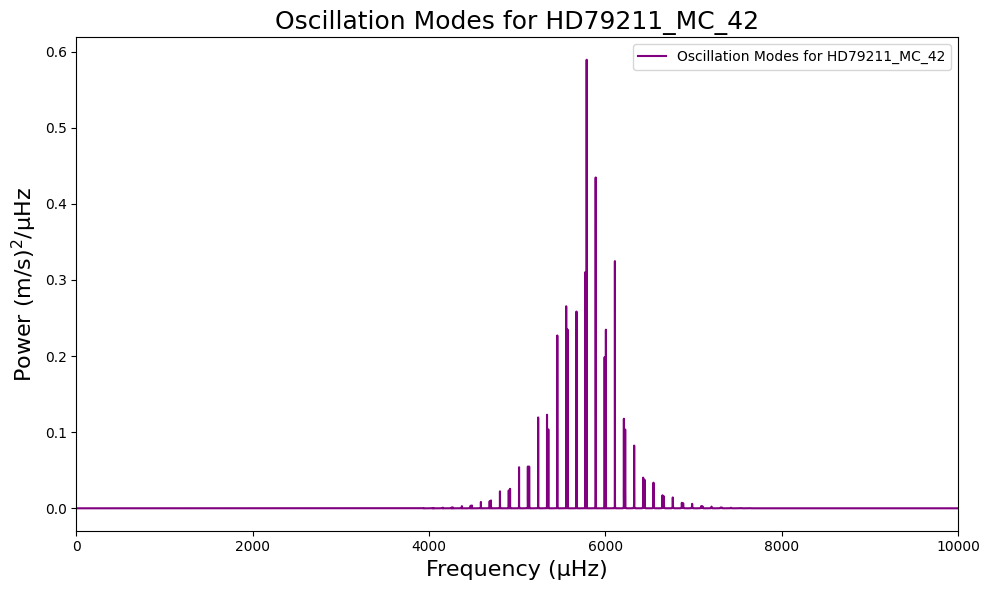

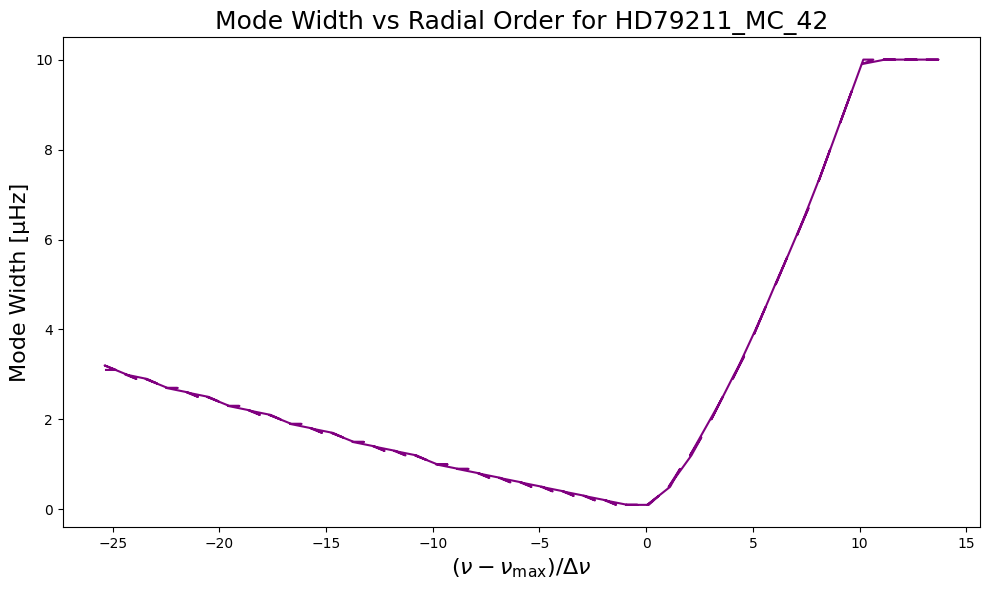

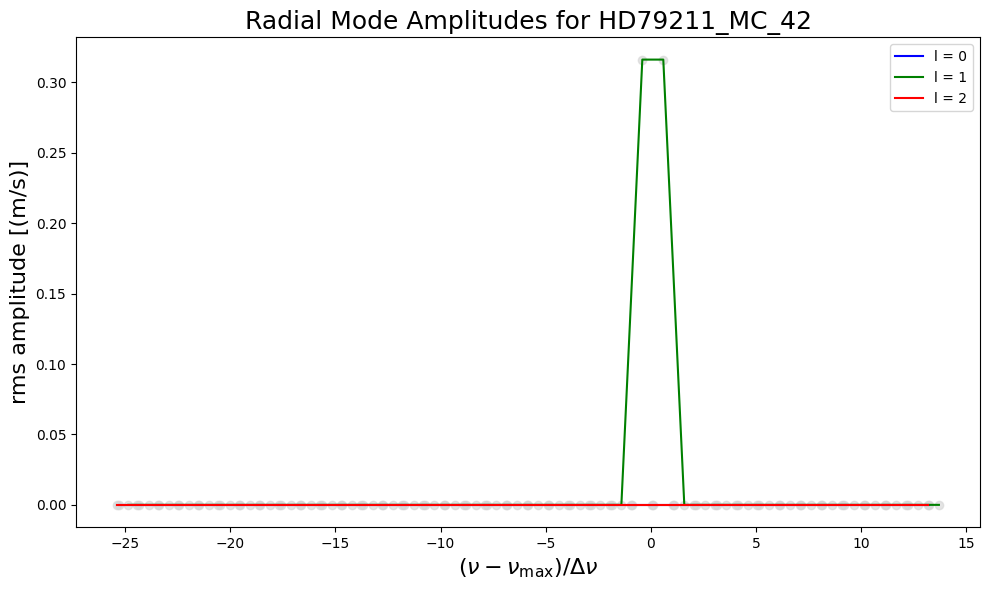

Mean δν₀₂: 14.585 μHz


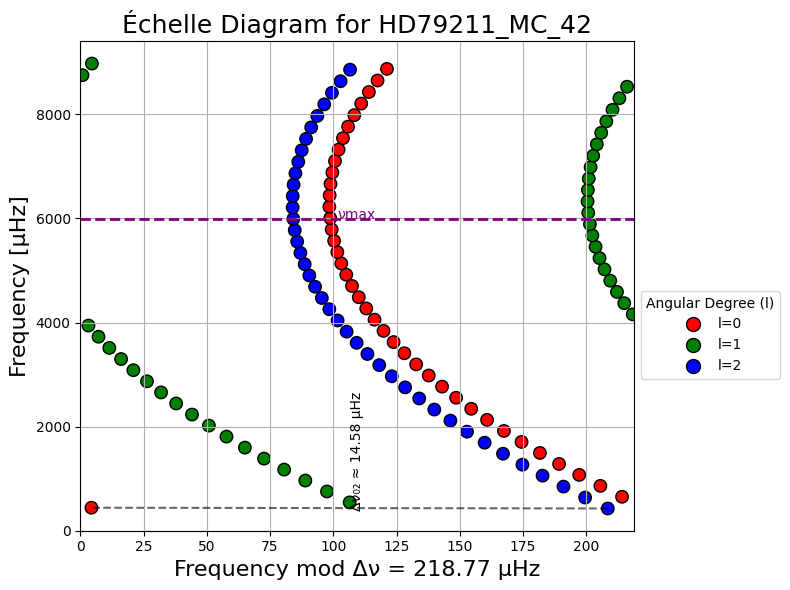

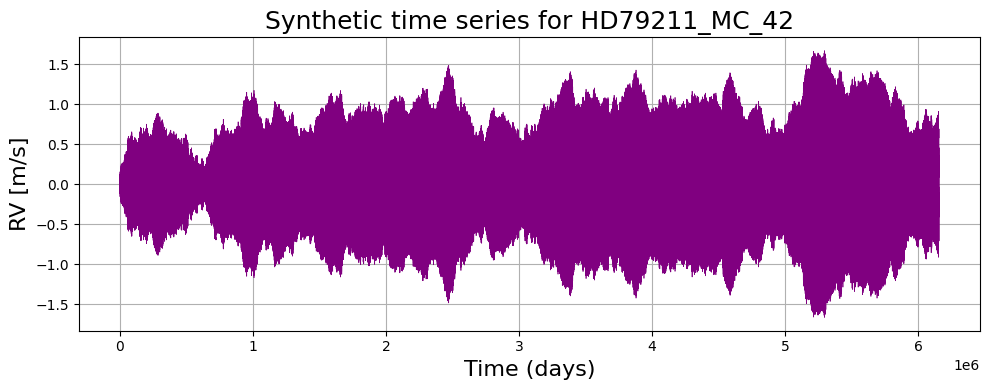

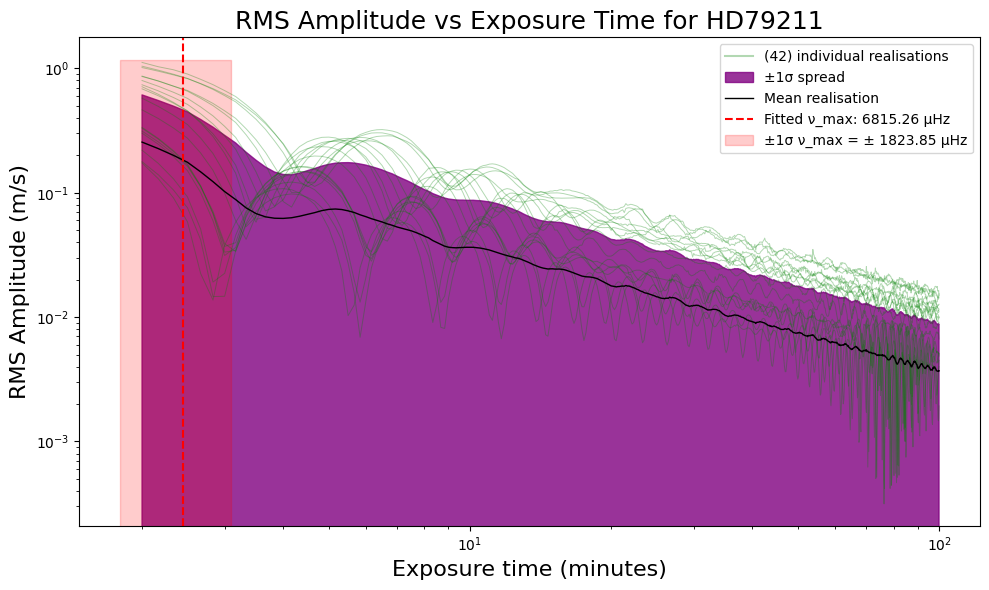

In [6]:
#Plot the results of the analysis
#---------------------------------------------------#
 
results = run_analysis(
    sample=sample,
    star_name=f"{star_id}",         # Input desired star name from the sample
    mc_index=42,                    # Input desired Monte Carlo realisation index
    base_path=base_path,
    generate_oscillation=True,      #Toggle to generate PSD of P-modes
    generate_linewidth=True,        #Toggle to generate linewidth vs frequency plot
    generate_amplitude=True,        #Toggle to generate amplitude by degree plot
    generate_echelle=True,          #Toggle to generate echelle diagram
    generate_time_series=True,      #Toggle to generate synthetic time series plot
    generate_from_npz=True          #Toggle to generate residual amplitude plot
)

In [7]:
npz_path = os.path.join(star_folder, os.path.basename(star_folder.rstrip("/")) + ".npz")

#User Inputs for RMS estimation
#---------------------------------------------------#
exposure_time_min = 5.0     # Set desired exposure time in minutes for P-mode RMS estimation    
target_rms = 0.1            # Set target RMS value in m/s for time estimation

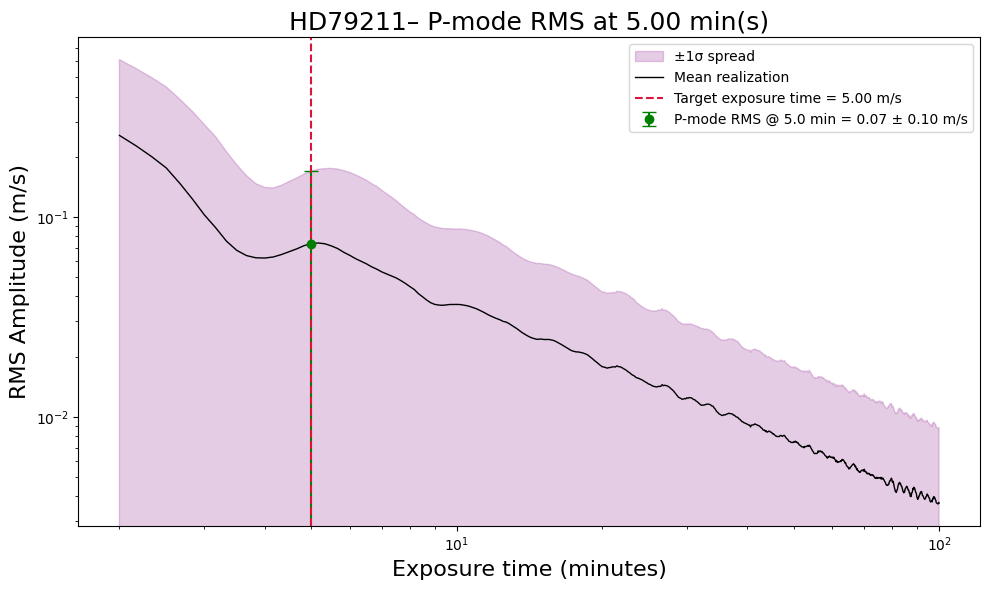

In [8]:
# Get P-mode RMS amplitude for a specific exposure time
get_rms_for_time(npz_path, exposure_time_min=5.0)


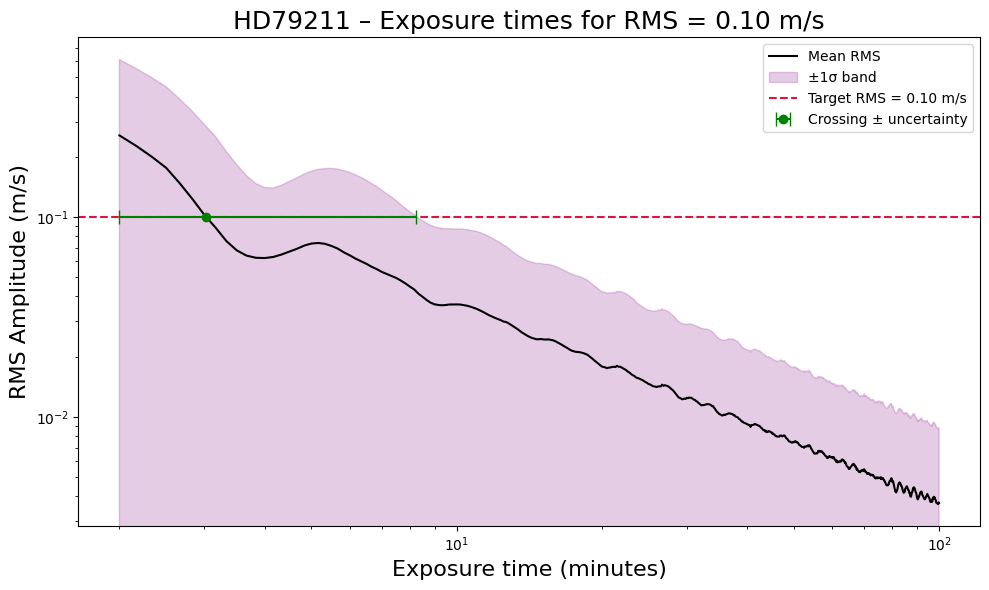

In [9]:
# Get exposure times to achieve a specific target RMS value
#---------------------------------------------------#
min_time, time_err = get_time_for_rms(npz_path, target_rms=target_rms)
